In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

In [156]:
# 시드 고정
seed = 22

In [157]:
# 전처리된 데이터 불러오기
df = pd.read_csv('./data/preprocessed_data.csv')

<Axes: xlabel='fire'>

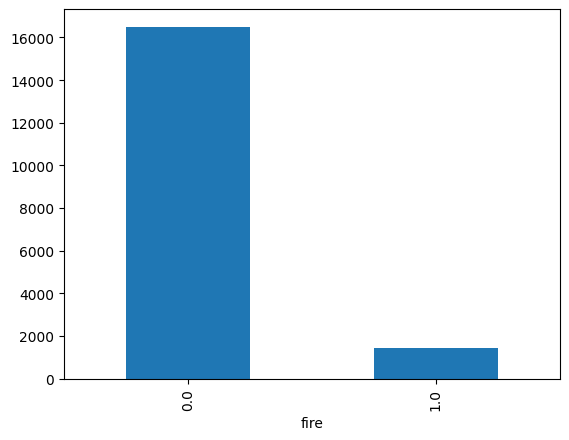

In [158]:
# 불이 안난 경우가 훨씬 많음
df['fire'].value_counts().plot.bar()

# 1. Random Undersampling

In [159]:
# 랜덤 언더샘플링으로 화재 발생하지 않은 지역 중 무작위 샘플링으로 라벨 적은 쪽과 개수 맞추기
shuffled_df = df.sample(frac=1, random_state=seed)

fire_df = shuffled_df.loc[shuffled_df['fire'] != 0]
non_fire_df = shuffled_df.loc[shuffled_df['fire'] == 0][:len(fire_df)]

norm_df = pd.concat([fire_df, non_fire_df])
rand_sub_df = norm_df.sample(frac=1, random_state=seed)

rand_sub_df.head()

,month,x,y,pop_rate,old_pop_rate,sto_num,barn_spwn_num,avg_temp,min_temp,max_temp,avg_hum,daily_pre,avg_wind,field_fire,green_fire,fire
1850,2,0.642857,0.714286,0.974965,0.732883,0.000000,0.0,0.365285,0.432507,0.320388,0.900735,0.195187,0.212121,0.571429,0.571429,1.0
4283,8,0.571429,0.285714,0.037543,0.091538,0.018868,0.0,0.898964,0.961433,0.798544,0.612132,0.000000,0.454545,0.142857,0.142857,0.0
10232,4,0.357143,0.285714,0.021799,0.048211,0.056604,0.0,0.536269,0.537190,0.541262,0.619485,0.000000,0.212121,0.000000,0.000000,0.0
10272,4,0.571429,0.642857,0.341915,0.417507,0.358491,0.0,0.536269,0.537190,0.541262,0.619485,0.000000,0.212121,0.571429,0.571429,1.0
10485,6,0.142857,0.642857,0.017771,0.037122,0.056604,0.0,0.753886,0.707989,0.813107,0.347426,0.000000,0.333333,0.285714,0.285714,1.0


<Axes: xlabel='fire'>

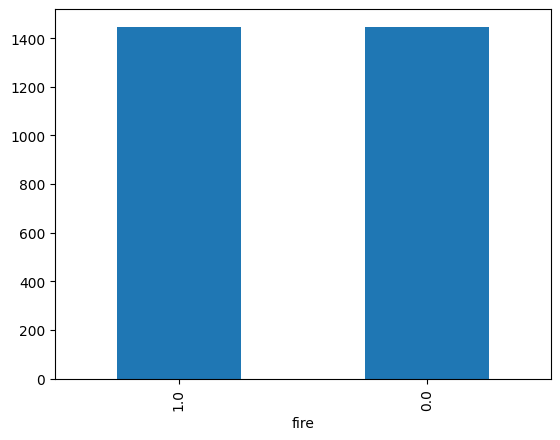

In [160]:
# 불이 난 경우와 안난 경우가 같아짐
rand_sub_df['fire'].value_counts().plot.bar()

<Axes: >

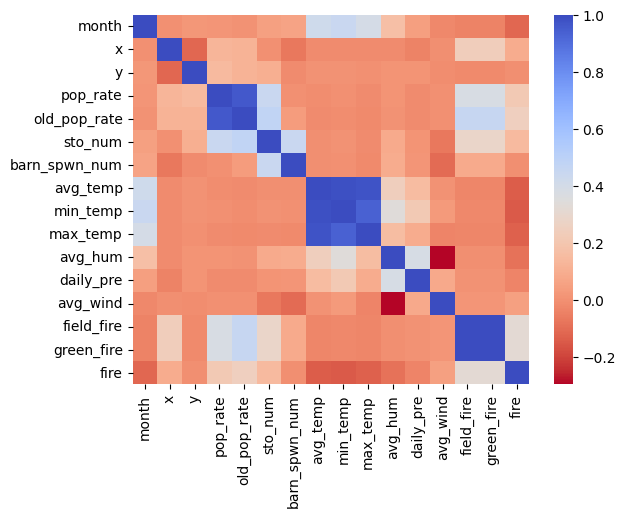

In [161]:
# 변수별 상관관계 분석
corr_under = rand_sub_df.corr()
sns.heatmap(corr_under, cmap='coolwarm_r')

In [162]:
# 변수별 상관관계 조사
corr_under['fire'].sort_values(ascending=False)

fire             1.000000
field_fire       0.318735
green_fire       0.318735
old_pop_rate     0.250612
pop_rate         0.214544
sto_num          0.148041
x                0.092901
avg_wind         0.051442
y               -0.003691
barn_spwn_num   -0.005124
daily_pre       -0.035464
avg_hum         -0.085533
month           -0.116969
max_temp        -0.133586
avg_temp        -0.141111
min_temp        -0.145090
Name: fire, dtype: float64

In [163]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score, average_precision_score

In [164]:
# train, test 데이터 스플릿
X = rand_sub_df.drop('fire', axis=1)
y = rand_sub_df['fire']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [165]:
# 모델 기본 파라미터로 학습
classifiers = {
    "로지스틱회귀": LogisticRegression(),
    "K최근접": KNeighborsClassifier(),
    "결정트리": DecisionTreeClassifier(),
    "랜덤포레스트": RandomForestClassifier(),
    "그라디언트부스팅": GradientBoostingClassifier()
}

for _, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print(classifier.__class__.__name__, "에서 학습 정확도", training_score.mean() * 100, "%")

LogisticRegression 에서 학습 정확도 65.96112311015119 %
KNeighborsClassifier 에서 학습 정확도 62.20302375809935 %
DecisionTreeClassifier 에서 학습 정확도 58.44492440604752 %
RandomForestClassifier 에서 학습 정확도 64.36285097192224 %
GradientBoostingClassifier 에서 학습 정확도 66.60907127429805 %


In [166]:
# 로지스틱회귀 하이퍼파라미터 튜닝
lr_params_under = {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

lr_grid_under = GridSearchCV(LogisticRegression(), lr_params_under)
lr_grid_under.fit(X_train, y_train)
lr_best_under = lr_grid_under.best_estimator_

print('최고예측정확도: {:.2f}%'.format(lr_grid_under.best_score_ * 100), '파라미터:', lr_grid_under.best_params_)

최고예측정확도: 66.39% 파라미터: {'C': 0.1, 'penalty': 'l2'}


In [167]:
# K최근접 하이퍼파라미터 튜닝
kn_params_under = {"n_neighbors": [2, 3, 4, 5], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

kn_grid_under = GridSearchCV(KNeighborsClassifier(), kn_params_under)
kn_grid_under.fit(X_train, y_train)
kn_best_under = kn_grid_under.best_estimator_

print('최고예측정확도: {:.2f}%'.format(kn_grid_under.best_score_ * 100), '파라미터:', kn_grid_under.best_params_)

최고예측정확도: 62.20% 파라미터: {'algorithm': 'auto', 'n_neighbors': 5}


In [168]:
# 결정트리 하이퍼파라미터 튜닝
dt_params_under = {"criterion": ["gini", "entropy"], "max_depth": [2, 3, 4, 5], "min_samples_leaf": [5, 6, 7, 8, 9]}

dt_grid_under = GridSearchCV(DecisionTreeClassifier(), dt_params_under)
dt_grid_under.fit(X_train, y_train)
dt_best_under = dt_grid_under.best_estimator_

print('최고예측정확도: {:.2f}%'.format(dt_grid_under.best_score_ * 100), '파라미터:', dt_grid_under.best_params_)

최고예측정확도: 65.44% 파라미터: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 5}


In [169]:
# 랜덤포레스트 하이퍼파라미터 튜닝
rf_params_under = { 'n_estimators' : [100], 'max_depth' : [4, 6, 8], 'min_samples_leaf' : [8, 12, 18, 20], 'min_samples_split' : [6, 8, 16]}

rf_grid_under = GridSearchCV(RandomForestClassifier(), rf_params_under)
rf_grid_under.fit(X_train, y_train)
rf_best_under = rf_grid_under.best_estimator_

print('최고예측정확도: {:.2f}%'.format(rf_grid_under.best_score_ * 100), '파라미터:', rf_grid_under.best_params_)

최고예측정확도: 67.47% 파라미터: {'max_depth': 4, 'min_samples_leaf': 8, 'min_samples_split': 16, 'n_estimators': 100}


In [170]:
# 그라디언트부스팅 하이퍼파라미터 튜닝
gb_params_under = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}

gb_grid_under = GridSearchCV(GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, max_features='sqrt', subsample=0.8, random_state=10), gb_params_under)
gb_grid_under.fit(X_train, y_train)
gb_best_under = gb_grid_under.best_estimator_

print('최고예측정확도: {:.2f}%'.format(gb_grid_under.best_score_ * 100), '파라미터:', gb_grid_under.best_params_)

최고예측정확도: 67.69% 파라미터: {'max_depth': 13, 'min_samples_split': 800}


In [171]:
# 모델 알고리즘 f1 스코어 cross validation
lr_score_f1_under = cross_val_score(lr_best_under, X_train, y_train, scoring='f1', cv=5).mean()
kn_score_f1_under = cross_val_score(kn_best_under, X_train, y_train, scoring='f1', cv=5).mean()
dt_score_f1_under = cross_val_score(dt_best_under, X_train, y_train, scoring='f1', cv=5).mean()
rf_score_f1_under = cross_val_score(rf_best_under, X_train, y_train, scoring='f1', cv=5).mean()
gb_score_f1_under = cross_val_score(gb_best_under, X_train, y_train, scoring='f1', cv=5).mean()

print('로지스틱 회귀 F1 스코어: {:.2f}%'.format(lr_score_f1_under * 100))
print('K최근접 F1 스코어: {:.2f}%'.format(kn_score_f1_under * 100))
print('결정트리 F1 스코어: {:.2f}%'.format(dt_score_f1_under * 100))
print('랜덤포레스트 F1 스코어: {:.2f}%'.format(rf_score_f1_under * 100))
print('그라디언트 부스팅 F1 스코어: {:.2f}%'.format(gb_score_f1_under * 100))

로지스틱 회귀 F1 스코어: 64.95%
K최근접 F1 스코어: 62.75%
결정트리 F1 스코어: 67.09%
랜덤포레스트 F1 스코어: 68.42%
그라디언트 부스팅 F1 스코어: 68.87%


In [172]:
# 모델 알고리즘 ROC AUC 스코어 cross validation
lr_pred_under = cross_val_predict(lr_best_under, X_train, y_train, cv=5, method="decision_function")
kn_pred_under = cross_val_predict(kn_best_under, X_train, y_train, cv=5)
dt_pred_under = cross_val_predict(dt_best_under, X_train, y_train, cv=5)
rf_pred_under = cross_val_predict(rf_best_under, X_train, y_train, cv=5)
gb_pred_under = cross_val_predict(gb_best_under, X_train, y_train, cv=5)

lr_score_auc_under = roc_auc_score(y_train, lr_pred_under)
kn_score_auc_under = roc_auc_score(y_train, kn_pred_under)
dt_score_auc_under = roc_auc_score(y_train, dt_pred_under)
rf_score_auc_under = roc_auc_score(y_train, rf_pred_under)
gb_score_auc_under = roc_auc_score(y_train, gb_pred_under)

print('로지스틱 회귀 ROC AUC 스코어: {:.5f}'.format(lr_score_auc_under))
print('K최근접 ROC AUC 스코어: {:.5f}'.format(kn_score_auc_under))
print('결정트리 ROC AUC 스코어: {:.5f}'.format(dt_score_auc_under))
print('랜덤포레스트 ROC AUC 스코어: {:.5f}'.format(rf_score_auc_under))
print('그라디언트 부스팅 ROC AUC 스코어: {:.5f}'.format(gb_score_auc_under))

로지스틱 회귀 ROC AUC 스코어: 0.71382
K최근접 ROC AUC 스코어: 0.62195
결정트리 ROC AUC 스코어: 0.65407
랜덤포레스트 ROC AUC 스코어: 0.66671
그라디언트 부스팅 ROC AUC 스코어: 0.67664


In [173]:
# 테스트 정확도
lr_test_pred_under = lr_best_under.predict(X_test)
kn_test_pred_under = kn_best_under.predict(X_test)
dt_test_pred_under = dt_best_under.predict(X_test)
rf_test_pred_under = rf_best_under.predict(X_test)
gb_test_pred_under = gb_best_under.predict(X_test)

lr_score_acc_under = accuracy_score(y_test, lr_test_pred_under)
kn_score_acc_under = accuracy_score(y_test, kn_test_pred_under)
dt_score_acc_under = accuracy_score(y_test, dt_test_pred_under)
rf_score_acc_under = accuracy_score(y_test, rf_test_pred_under)
gb_score_acc_under = accuracy_score(y_test, gb_test_pred_under)

print('테스트 로지스틱 회귀 정확도: {:.2f}%'.format(lr_score_acc_under * 100))
print('테스트 K최근접 정확도: {:.2f}%'.format(kn_score_acc_under * 100))
print('테스트 결정트리 정확도: {:.2f}%'.format(dt_score_acc_under * 100))
print('테스트 랜덤포레스트 정확도: {:.2f}%'.format(rf_score_acc_under * 100))
print('테스트 그라디언트 부스팅 정확도: {:.2f}%'.format(gb_score_acc_under * 100))

테스트 로지스틱 회귀 정확도: 68.39%
테스트 K최근접 정확도: 63.21%
테스트 결정트리 정확도: 67.88%
테스트 랜덤포레스트 정확도: 68.05%
테스트 그라디언트 부스팅 정확도: 68.91%


Random undersampling에서는 그라디언트 부스팅이 가장 좋은 성능

# 2. SMOTE Oversampling

In [174]:
# 데이터셋 스플릿
X = df.drop('fire', axis=1)
y = df['fire']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [176]:
# SMOTE 기법으로 오버샘플링
# 이를 통해 화재 발생 데이터를 분포에 맞춰 랜덤으로 생성하여 라벨 많은 쪽과 개수 맞추기
sm = SMOTE(sampling_strategy='auto', random_state=seed)

over_X_train, over_y_train = sm.fit_resample(X_train, y_train)

<Axes: xlabel='fire'>

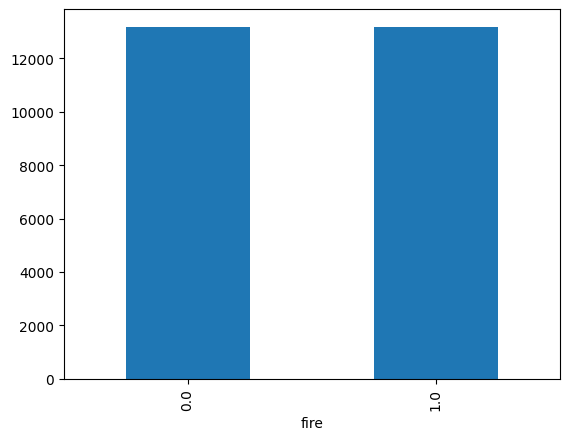

In [177]:
# 오버샘플링한 데이터 분포 확인
over_y_train.value_counts().plot.bar()

<Axes: >

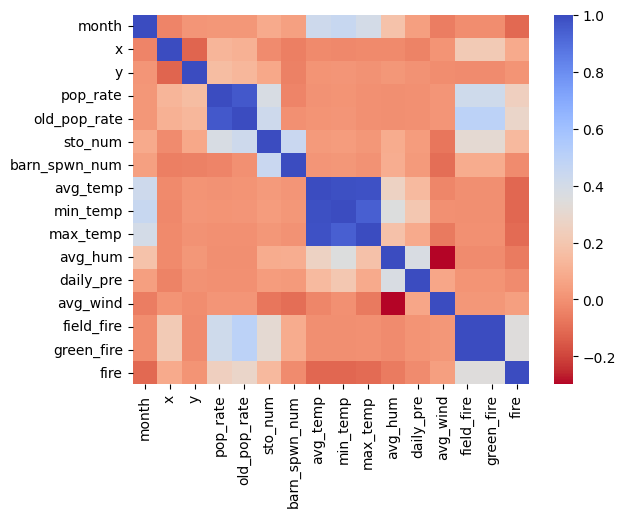

In [326]:
# 변수별 상관관계 분석
corr_df = over_X_train.copy()
corr_df['fire'] = over_y_train
corr_over = corr_df.corr()
sns.heatmap(corr_over, cmap='coolwarm_r')

In [327]:
# 변수별 상관관계 조사
corr_over['fire'].sort_values(ascending=False)

fire             1.000000
field_fire       0.344988
green_fire       0.344988
old_pop_rate     0.284540
pop_rate         0.246373
sto_num          0.138099
x                0.086236
avg_wind         0.042375
y                0.007963
daily_pre       -0.016419
barn_spwn_num   -0.018749
avg_hum         -0.062556
max_temp        -0.108573
month           -0.111803
avg_temp        -0.116140
min_temp        -0.120622
Name: fire, dtype: float64

In [178]:
# 모델 기본 파라미터로 학습
classifiers = {
    "로지스틱회귀": LogisticRegression(),
    "K최근접": KNeighborsClassifier(),
    "결정트리": DecisionTreeClassifier(),
    "랜덤포레스트": RandomForestClassifier(),
    "그라디언트 부스팅": GradientBoostingClassifier()
}

for _, classifier in classifiers.items():
    classifier.fit(over_X_train, over_y_train)
    training_score = cross_val_score(classifier, over_X_train, over_y_train, cv=5)
    print(classifier.__class__.__name__, "에서 학습 정확도", round(training_score.mean(), 2) * 100, "%")

LogisticRegression 에서 학습 정확도 68.0 %
KNeighborsClassifier 에서 학습 정확도 86.0 %
DecisionTreeClassifier 에서 학습 정확도 90.0 %
RandomForestClassifier 에서 학습 정확도 95.0 %
GradientBoostingClassifier 에서 학습 정확도 91.0 %


In [179]:
# 로지스틱회귀 하이퍼파라미터 튜닝
lr_params_over = {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

lr_grid_over = GridSearchCV(LogisticRegression(), lr_params_over)
lr_grid_over.fit(over_X_train, over_y_train)
lr_best_over = lr_grid_over.best_estimator_

print('최고예측정확도: {:.2f}%'.format(lr_grid_over.best_score_ * 100), '파라미터:', lr_grid_over.best_params_)

최고예측정확도: 67.83% 파라미터: {'C': 0.01, 'penalty': 'l2'}


In [180]:
# K최근접 하이퍼파라미터 튜닝
kn_params_over = {"n_neighbors": [2, 3, 4], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

kn_grid_over = GridSearchCV(KNeighborsClassifier(), kn_params_over)
kn_grid_over.fit(over_X_train, over_y_train)
kn_best_over = kn_grid_over.best_estimator_

print('최고예측정확도: {:.2f}%'.format(kn_grid_over.best_score_ * 100), '파라미터:', kn_grid_over.best_params_)

최고예측정확도: 92.03% 파라미터: {'algorithm': 'auto', 'n_neighbors': 2}


In [181]:
# 결정트리 하이퍼파라미터 튜닝
dt_params_over = {"criterion": ["gini", "entropy"], "max_depth": [None], "min_samples_leaf": [1, 5, 6, 7, 8, 9]}

dt_grid_over = GridSearchCV(DecisionTreeClassifier(), dt_params_over)
dt_grid_over.fit(over_X_train, over_y_train)
dt_best_over = dt_grid_over.best_estimator_

print('최고예측정확도: {:.2f}%'.format(dt_grid_over.best_score_ * 100), '파라미터:', dt_grid_over.best_params_)

최고예측정확도: 90.74% 파라미터: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1}


In [182]:
# 랜덤포레스트 하이퍼파라미터 튜닝
rf_params_over = { 'n_estimators' : [100], 'max_depth' : [None], 'min_samples_leaf' : [1, 8, 12, 18, 20], 'min_samples_split' : [2, 6, 8, 16]}

rf_grid_over = GridSearchCV(RandomForestClassifier(), rf_params_over)
rf_grid_over.fit(over_X_train, over_y_train)
rf_best_over = rf_grid_over.best_estimator_

print('최고예측정확도: {:.2f}%'.format(rf_grid_over.best_score_ * 100), '파라미터:', rf_grid_over.best_params_)

최고예측정확도: 95.05% 파라미터: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [183]:
# 그라디언트부스팅 하이퍼파라미터 튜닝
gb_params_over = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}

gb_grid_over = GridSearchCV(GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, max_features='sqrt', subsample=0.8, random_state=10), gb_params_over)
gb_grid_over.fit(over_X_train, over_y_train)
gb_best_over = gb_grid_over.best_estimator_

print('최고예측정확도: {:.2f}%'.format(gb_grid_over.best_score_ * 100), '파라미터:', gb_grid_over.best_params_)

최고예측정확도: 94.23% 파라미터: {'max_depth': 15, 'min_samples_split': 200}


In [184]:
# 모델 알고리즘 f1 스코어 cross validation
lr_score_f1_over = cross_val_score(lr_best_over, over_X_train, over_y_train, scoring='f1', cv=5).mean()
kn_score_f1_over = cross_val_score(kn_best_over, over_X_train, over_y_train, scoring='f1', cv=5).mean()
dt_score_f1_over = cross_val_score(dt_best_over, over_X_train, over_y_train, scoring='f1', cv=5).mean()
rf_score_f1_over = cross_val_score(rf_best_over, over_X_train, over_y_train, scoring='f1', cv=5).mean()
gb_score_f1_over = cross_val_score(gb_best_over, over_X_train, over_y_train, scoring='f1', cv=5).mean()

print('로지스틱 회귀 F1 스코어: {:.2f}%'.format(lr_score_f1_over * 100))
print('K최근접 F1 스코어: {:.2f}%'.format(kn_score_f1_over * 100))
print('결정트리 F1 스코어: {:.2f}%'.format(dt_score_f1_over * 100))
print('랜덤포레스트 F1 스코어: {:.2f}%'.format(rf_score_f1_over * 100))
print('그라디언트 부스팅 F1 스코어: {:.2f}%'.format(gb_score_f1_over * 100))

로지스틱 회귀 F1 스코어: 65.80%
K최근접 F1 스코어: 92.34%
결정트리 F1 스코어: 90.18%
랜덤포레스트 F1 스코어: 94.48%
그라디언트 부스팅 F1 스코어: 93.29%


In [185]:
# 모델 알고리즘 ROC AUC 스코어 cross validation
lr_pred_over = cross_val_predict(lr_best_over, over_X_train, over_y_train, cv=5, method="decision_function")
kn_pred_over = cross_val_predict(kn_best_over, over_X_train, over_y_train, cv=5)
dt_pred_over = cross_val_predict(dt_best_over, over_X_train, over_y_train, cv=5)
rf_pred_over = cross_val_predict(rf_best_over, over_X_train, over_y_train, cv=5)
gb_pred_over = cross_val_predict(gb_best_over, over_X_train, over_y_train, cv=5)


lr_score_auc_over = roc_auc_score(over_y_train, lr_pred_over)
kn_score_auc_over = roc_auc_score(over_y_train, kn_pred_over)
dt_score_auc_over = roc_auc_score(over_y_train, dt_pred_over)
rf_score_auc_over = roc_auc_score(over_y_train, rf_pred_over)
gb_score_auc_over = roc_auc_score(over_y_train, gb_pred_over)

print('로지스틱 회귀 ROC AUC 스코어: {:.5f}'.format(lr_score_auc_over))
print('K최근접 ROC AUC 스코어: {:.5f}'.format(kn_score_auc_over))
print('결정트리 ROC AUC 스코어: {:.5f}'.format(dt_score_auc_over))
print('랜덤포레스트 ROC AUC 스코어: {:.5f}'.format(rf_score_auc_over))
print('그라디언트 부스팅 ROC AUC 스코어: {:.5f}'.format(gb_score_auc_over))

로지스틱 회귀 ROC AUC 스코어: 0.73855
K최근접 ROC AUC 스코어: 0.92029
결정트리 ROC AUC 스코어: 0.90846
랜덤포레스트 ROC AUC 스코어: 0.95025
그라디언트 부스팅 ROC AUC 스코어: 0.94233


In [186]:
# 테스트 정확도
lr_test_pred_over = lr_best_over.predict(X_test)
kn_test_pred_over = kn_best_over.predict(X_test)
dt_test_pred_over = dt_best_over.predict(X_test)
rf_test_pred_over = rf_best_over.predict(X_test)
gb_test_pred_over = gb_best_over.predict(X_test)

lr_score_acc_over = accuracy_score(y_test, lr_test_pred_over)
kn_score_acc_over = accuracy_score(y_test, kn_test_pred_over)
dt_score_acc_over = accuracy_score(y_test, dt_test_pred_over)
rf_score_acc_over = accuracy_score(y_test, rf_test_pred_over)
gb_score_acc_over = accuracy_score(y_test, gb_test_pred_over)

print('테스트 로지스틱 회귀 정확도: {:.2f}%'.format(lr_score_acc_over * 100))
print('테스트 K최근접 정확도: {:.2f}%'.format(kn_score_acc_over * 100))
print('테스트 결정트리 정확도: {:.2f}%'.format(dt_score_acc_over * 100))
print('테스트 랜덤포레스트 정확도: {:.2f}%'.format(rf_score_acc_over * 100))
print('테스트 그라디언트 부스팅 정확도: {:.2f}%'.format(gb_score_acc_over * 100))

테스트 로지스틱 회귀 정확도: 70.98%
테스트 K최근접 정확도: 84.13%
테스트 결정트리 정확도: 83.57%
테스트 랜덤포레스트 정확도: 90.42%
테스트 그라디언트 부스팅 정확도: 89.97%


SMOTE oversampling의 경우 랜덤포레스트 모델이 가장 좋은 성능

In [187]:
# 각 샘플링별 랜덤포레스트 결과 종합
results = [
    ['Random Undersampling', rf_score_f1_under, rf_score_auc_under, rf_score_acc_under],
    ['SMOTE Oversampling', rf_score_f1_over, rf_score_auc_over, rf_score_acc_over]
]

pd.DataFrame(results, columns=['sampling_method', 'train_f1_score', 'train_auc_score', 'test_accuracy'])

,sampling_method,train_f1_score,train_auc_score,test_accuracy
0,Random Undersampling,0.684155,0.666705,0.680484
1,SMOTE Oversampling,0.944811,0.950250,0.904205


In [188]:
# 각 샘플링별 그라디언트 부스팅 결과 종합
results = [
    ['Random Undersampling', gb_score_f1_under, gb_score_auc_under, gb_score_acc_under],
    ['SMOTE Oversampling', gb_score_f1_over, gb_score_auc_over, gb_score_acc_over]
]

pd.DataFrame(results, columns=['sampling_method', 'train_f1_score', 'train_auc_score', 'test_accuracy'])

,sampling_method,train_f1_score,train_auc_score,test_accuracy
0,Random Undersampling,0.688718,0.676644,0.689119
1,SMOTE Oversampling,0.932913,0.942325,0.899749


In [189]:
# 학습된 SMOTE oversampling의 랜덤포레스트 및 그라디언트 부스팅 모델 저장
import joblib 

joblib.dump(rf_best_over, 'rf_model_over.pkl')
joblib.dump(gb_best_over, 'gb_model_over.pkl')

['gb_model_over.pkl']